In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon Jun 04 11:33:08 2018

@author: Rufus
"""

import grv
import dt1m
import numpy as np
import matplotlib.pyplot as plt
import ehtim as eh
import ehtim.scattering as so
from vlbi import image2visibility
from astroray_io import write_image_EHTimagelib

number_of_realization = 1
alpha_Is = np.array([-2.])
alpha_L1 = -2.0
alpha_L2 = 2.0
pix_x=152
pix_y=152
image_size_M=12.2
M2Rad = 4.3e6*2e33*6.67e-8/(3e10)**2/(8e3*3.086e18)
image_size_rad = image_size_M*M2Rad
k,l = np.mgrid[-image_size_rad:image_size_rad:pix_x*1j,-image_size_rad:image_size_rad:pix_y*1j]
pad = 0

X = np.linspace(-1,1,pix_x)*image_size_M
Y = np.linspace(-1,1,pix_y)*image_size_M
image = np.zeros((pix_x,pix_y,4))

sm = so.ScatteringModel()

for alpha_I in alpha_Is:

    vis_t_avg_I = np.zeros(pix_x*pix_y*(2**pad)**2).reshape(pix_x*2**pad,pix_y*2**pad)
    vis_t_avg_L1 = np.zeros(pix_x*pix_y*(2**pad)**2).reshape(pix_x*2**pad,pix_y*2**pad)
    vis_t_avg_L2 = np.zeros(pix_x*pix_y*(2**pad)**2).reshape(pix_x*2**pad,pix_y*2**pad)
    vis_scattered_t_avg_I = np.zeros(pix_x*pix_y*(2**pad)**2).reshape(pix_x*2**pad,pix_y*2**pad)
    vis_scattered_t_avg_L1 = np.zeros(pix_x*pix_y*(2**pad)**2).reshape(pix_x*2**pad,pix_y*2**pad)
    vis_scattered_t_avg_L2 = np.zeros(pix_x*pix_y*(2**pad)**2).reshape(pix_x*2**pad,pix_y*2**pad)# visiblity squared
    
    vis_I = np.zeros(pix_x*pix_y*(2**pad)**2).reshape(pix_x*2**pad,pix_y*2**pad)
    vis_L1 = np.zeros(pix_x*pix_y*(2**pad)**2).reshape(pix_x*2**pad,pix_y*2**pad)
    vis_L2 = np.zeros(pix_x*pix_y*(2**pad)**2).reshape(pix_x*2**pad,pix_y*2**pad)
    vis_scattered_I = np.zeros(pix_x*pix_y*(2**pad)**2).reshape(pix_x*2**pad,pix_y*2**pad)
    vis_scattered_L1 = np.zeros(pix_x*pix_y*(2**pad)**2).reshape(pix_x*2**pad,pix_y*2**pad)
    vis_scattered_L2 = np.zeros(pix_x*pix_y*(2**pad)**2).reshape(pix_x*2**pad,pix_y*2**pad)# visibility
    
#    vis_t_avg_resolution = np.zeros(pix_x*pix_y*(2**pad)**2).reshape(pix_x*2**pad,pix_y*2**pad)
#    image_avg_resolution = np.zeros(pix_x*pix_y).reshape(pix_x,pix_y)
    
    for count in range(number_of_realization):
        g_I = grv.grv(scatt_alpha=alpha_I)
        g_L1 = grv.grv(scatt_alpha=alpha_L1)#the image w/ grv noise; the image w/o grv noise; noise itself
        g_L2 = grv.grv(scatt_alpha=alpha_L2)
        for ix in np.arange(np.size(X)):
            for iy in np.arange(np.size(Y)):
                for IQUV in np.arange(4):
                    if IQUV == 1:
                        image[ix,iy,IQUV] = np.exp(-(X[ix]**2+Y[iy]**2)/image_size_M*2)*np.exp(g_I[ix,iy])*g_L1[ix,iy]#L1
                    elif IQUV == 2:
                        image[ix,iy,IQUV] = np.exp(-(X[ix]**2+Y[iy]**2)/image_size_M*2)*np.exp(g_I[ix,iy])*g_L2[ix,iy]#L2
                    elif IQUV == 0:
                        image[ix,iy,IQUV] = np.exp(-(X[ix]**2+Y[iy]**2)/image_size_M*2)*np.exp(g_I[ix,iy])#I
                    else:
                        image[ix,iy,IQUV] = np.exp(-(X[ix]**2+Y[iy]**2)/image_size_M*2)#I without fluctuations
                        
        write_image_EHTimagelib(image,'astroray_230GHz_IQUV.txt',nu=230.,dx=1.5e-6,dy=1.5e-6)
        eht_image_obj = eh.image.load_txt('./astroray_230GHz_IQUV.txt')
        screen = so.MakeEpsilonScreen(eht_image_obj.xdim, eht_image_obj.ydim, rngseed=None)
        I_scattered_obj = sm.Scatter(eht_image_obj,screen)
        I_array = I_scattered_obj.imvec.reshape(I_scattered_obj.ydim,I_scattered_obj.xdim)
        L1_array = I_scattered_obj.qvec.reshape(I_scattered_obj.ydim,I_scattered_obj.xdim)
        L2_array = I_scattered_obj.uvec.reshape(I_scattered_obj.ydim,I_scattered_obj.xdim)
        
        u,v,visibility_I = dt1m.compute_complex_visibilities(k,l,image[:,:,0],Npad=pad,return_uv=True)
        visibility_L1 = dt1m.compute_complex_visibilities(k,l,image[:,:,1],Npad=pad,return_uv=False)
        visibility_L2 = dt1m.compute_complex_visibilities(k,l,image[:,:,2],Npad=pad,return_uv=False)
        visibility_scattered_I = dt1m.compute_complex_visibilities(k,l,I_array,Npad=pad,return_uv=False)
        visibility_scattered_L1 = dt1m.compute_complex_visibilities(k,l,L1_array,Npad=pad,return_uv=False)
        visibility_scattered_L2 = dt1m.compute_complex_visibilities(k,l,L2_array,Npad=pad,return_uv=False)
        
#        visibility_I, u, v = image2visibility(image[:,:,0],zeropadding_factor=1,return_uv=True,image_size_inM_x=24.4,image_size_inM_y=24.4)
#        visibility_L = image2visibility(image[:,:,1],zeropadding_factor=1)
#        visibility_scattered_I = image2visibility(I_array, zeropadding_factor=1)
#        visibility_scattered_L = image2visibility(L_array, zeropadding_factor=1)
        
        vis_I += abs(visibility_I)  
        vis_L1 += abs(visibility_L1)
        vis_L2 += abs(visibility_L2)
        vis_scattered_I += abs(vis_scattered_t_avg_I)
        vis_scattered_L1 += abs(vis_scattered_t_avg_L1)
        vis_scattered_L2 += abs(vis_scattered_t_avg_L2)

        vis_t_avg_I += abs(visibility_I)**2
        vis_t_avg_L1 += abs(visibility_L1)**2
        vis_t_avg_L2 += abs(visibility_L2)**2
        vis_scattered_t_avg_I += abs(visibility_scattered_I)**2
        vis_scattered_t_avg_L1 += abs(visibility_scattered_L1)**2
        vis_scattered_t_avg_L2 += abs(visibility_scattered_L2)**2
        
#        image_avg = image[:,:,0]
#        vis_t_avg = abs(visibility_I)
#        image_avg_resolution += image_avg
#        vis_t_avg_resolution += vis_t_avg
        
    vis_I = vis_I/number_of_realization
    vis_L1 = vis_L1/number_of_realization
    vis_L2 = vis_L2/number_of_realization
    vis_scattered_I = vis_scattered_I/number_of_realization
    vis_scattered_L1 = vis_scattered_L1/number_of_realization
    vis_scattered_L2 = vis_scattered_L2/number_of_realization
    
    vis_t_avg_I = vis_t_avg_I/number_of_realization
    vis_t_avg_L1 = vis_t_avg_L1/number_of_realization
    vis_t_avg_L2 = vis_t_avg_L2/number_of_realization
    vis_scattered_t_avg_I = vis_scattered_t_avg_I/number_of_realization
    vis_scattered_t_avg_L1 = vis_scattered_t_avg_L1/number_of_realization
    vis_scattered_t_avg_L2 = vis_scattered_t_avg_L2/number_of_realization
        
#    image_avg_resolution = image_avg_resolution/number_of_realization
#    vis_t_avg_resolution = vis_t_avg_resolution/number_of_realization
    
    plt.figure(1,figsize=(2,2))
    plt.gca().set_position([0.15,0.15,0.8,0.8])
    plt.imshow(image[:,:,3], origin='lower',extent=(-12.2,12.2,-12.2,12.2))
    plt.xlabel('M')
    plt.ylabel('M')
    plt.title('Intrinsic intensity without fluctuation')
    plt.savefig('snapshot_of_intrinsic_intensity_without_fluctuation_toy_model.png')
    
    plt.figure(2,figsize=(2,2))
    plt.gca().set_position([0.15,0.15,0.8,0.8])
    plt.imshow(image[:,:,0], origin='lower',extent=(-12.2,12.2,-12.2,12.2))
    plt.xlabel('M')
    plt.ylabel('M')
    plt.title('Intrinsic intensity with fluctuation')
    plt.savefig('snapshot_of_intrinsic_intensity_with_fluctuation_toy_model.png')
    
    plt.figure(3,figsize=(2,2))
    plt.gca().set_position([0.15,0.15,0.8,0.8])
    plt.imshow(image[:,:,1], origin='lower',extent=(-12.2,12.2,-12.2,12.2))
    plt.xlabel('M')
    plt.ylabel('M')
    plt.title('Intrinsic polarized intensity')
    plt.savefig('snapshot_of_intrinsic_polarized_intensity_toy_model.png')
    
    plt.figure(4,figsize=(2,2))
    plt.gca().set_position([0.15,0.15,0.8,0.8])
    plt.imshow(I_array, origin='lower',extent=(-12.2,12.2,-12.2,12.2))
    plt.xlabel('M')
    plt.ylabel('M')
    plt.title('Scattered intensity')
    plt.savefig('snapshot_of_scattered_intensity_toy_model.png')
    
    plt.figure(5,figsize=(2,2))
    plt.gca().set_position([0.15,0.15,0.8,0.8])
    plt.imshow(L1_array, origin='lower',extent=(-12.2,12.2,-12.2,12.2))
    plt.xlabel('M')
    plt.ylabel('M')
    plt.title('Scattered polarized intensity')
    plt.savefig('snapshot_of_scattered_polarized_intensity_toy_model.png')
    
    plt.figure(6,figsize=(2,2))
    plt.gca().set_position([0.15,0.15,0.8,0.8])
    plt.imshow(g_L1, origin='lower',extent=(-12.2,12.2,-12.2,12.2))
    plt.xlabel('M')
    plt.ylabel('M')
    plt.title('Gaussian random field that generates the polarization')
    plt.savefig('g_L_generates_polarization.png')
    
#    plt.figure(1,figsize=(10,10))
#    plt.semilogy(np.sort(u[:,0])*1e-9,vis_t_avg_I[np.size(u[:,0])/2,:],label = 'I:Intrinsic', color='darkred')
#    plt.xlabel("$u$ $(G\lambda)$")
#    plt.ylabel("$<V_{I}^2>$")
#    #plt.axis((0,15,1e-1,1e8))
#    plt.tick_params(axis='both')
#    plt.legend(frameon=False)
#    leg = plt.legend()
#    leg.get_frame().set_linewidth(0.0)
    
#    plt.figure(1,figsize=(10, 10))
#    plt.semilogy(np.sort(u[:,0])*1e-9,vis_t_avg_resolution[np.size(u[:,0])/2,:],label = alpha_I)
#    #plt.semilogy(np.sort(u[:,0]),image_avg_resolution[np.size(u[:,0])/2,:],label = "gauss")
#    plt.axis((0,15,1e-2,1e4))
#    plt.xlabel("$U$",fontsize=15)
#    plt.ylabel("$<visibility^2>$",fontsize=15)
#    plt.title("visbility after scattering")
#    plt.legend()
#    leg = plt.legend()
#    leg.get_frame().set_linewidth(0.0)
##    
#    plt.figure(2,figsize=(10, 10))
#    plt.semilogy(np.sort(u[:,0])*1e-9,vis_scattered_t_avg_L2[np.size(u[:,0])/2,:]/vis_scattered_t_avg_L1[np.size(u[:,0])/2,:],label = 'scattered')
#    plt.semilogy(np.sort(u[:,0])*1e-9,vis_t_avg_L2[np.size(u[:,0])/2,:]/vis_t_avg_L1[np.size(u[:,0])/2,:],label = 'intrinsic')
#    #plt.semilogy(np.sort(u[:,0]),image_avg_resolution[np.size(u[:,0])/2,:],label = "gauss")
#    plt.axis((0,15,1e-8,1e2))
#    plt.xlabel("$U$",fontsize=15)
#    plt.ylabel("$<visibility^2>$",fontsize=15)
#    plt.title("Ratio of V_I vs V_L before and after scattering")
#    plt.legend()
#    leg = plt.legend()
#    leg.get_frame().set_linewidth(0.0)

Welcome to eht-imaging v 1.0.0
Loading text image:  ./astroray_230GHz_IQUV.txt
The image dimension should really be odd...


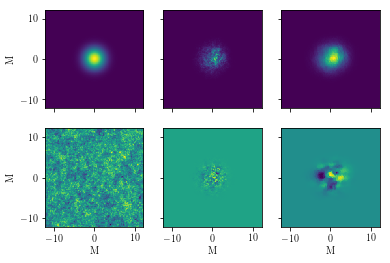

In [16]:
    plt.figure(1)
    plt.gca().set_position([0.15,0.15,0.75,0.75])
    plt.subplot(231)
    plt.imshow(image[:,:,3], origin='lower',extent=(-12.2,12.2,-12.2,12.2)) #intrinsic I without fluc
    plt.ylabel('M')
    plt.xticks([-10,0,10])
    plt.yticks([-10,0,10])
    plt.gca().xaxis.set_ticklabels([])
    plt.subplot(232)
    plt.imshow(image[:,:,0], origin='lower',extent=(-12.2,12.2,-12.2,12.2)) #Intrinsic I with fluc
    plt.xticks([-10,0,10])
    plt.yticks([-10,0,10])
    plt.gca().xaxis.set_ticklabels([])
    plt.gca().yaxis.set_ticklabels([])
    plt.subplot(233)
    plt.imshow(I_array, origin='lower',extent=(-12.2,12.2,-12.2,12.2)) #Scattered I with fluc
    plt.xticks([-10,0,10])
    plt.yticks([-10,0,10])
    plt.gca().xaxis.set_ticklabels([])
    plt.gca().yaxis.set_ticklabels([])
    plt.subplot(234)
    plt.imshow(g_L1, origin='lower',extent=(-12.2,12.2,-12.2,12.2)) #Gaussian random field that generates L1
    plt.xticks([-10,0,10])
    plt.yticks([-10,0,10])
    plt.xlabel('M')
    plt.ylabel('M')
    plt.subplot(235)
    plt.imshow(image[:,:,1], origin='lower',extent=(-12.2,12.2,-12.2,12.2)) #Intrinsic L1
    plt.xticks([-10,0,10])
    plt.yticks([-10,0,10])
    plt.xlabel('M')
    plt.gca().yaxis.set_ticklabels([])
    plt.subplot(236)
    plt.imshow(L1_array, origin='lower',extent=(-12.2,12.2,-12.2,12.2)) #scattered L1
    plt.xticks([-10,0,10])
    plt.yticks([-10,0,10])
    plt.xlabel('M')
    plt.gca().yaxis.set_ticklabels([])
    plt.savefig('toy_model_pic.png',dpi=600)

[]

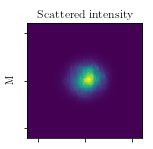

In [14]:
    plt.figure(4,figsize=(2,2))
    plt.gca().set_position([0.15,0.15,0.8,0.8])
    plt.imshow(I_array, origin='lower',extent=(-12.2,12.2,-12.2,12.2))
    #plt.xlabel('M')
    plt.ylabel('M')
    plt.xticks([-10,0,10])
    plt.yticks([-10,0,10])
    plt.title('Scattered intensity')
    #plt.savefig('snapshot_of_scattered_intensity_toy_model.png')
    plt.gca().xaxis.set_ticklabels([])
    plt.gca().yaxis.set_ticklabels([])
    #plt.gca().get_xaxis().set_visible(False)